In [5]:
# %matplotlib widget
import numpy as np
from matplotlib import pyplot as plt

import scipy
from scipy.optimize import curve_fit


**Functions**

In [ ]:
def fit(function,x,y,p0=None,sigma=None,bounds=[None,None]):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma,bounds=bounds)
    xc = np.linspace(min(x),max(x),100)
    curve = function(xc,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,xc,curve,perr

**Settings**

In [6]:
outputdir = '/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/output/'

In [7]:
!ls ../../../mb/npys/

4epix_Lab6_231103.poni	 det_img3_Sibeee_new.npy     usuck_img_run80_frame1.npy
AhBh_asselmbles.npy	 det_img3_Sibeee.npy	     usuck_img_run80_frame2.npy
det_img0.npy		 det_img4_Sibeee_new.npy     usuck_img_run80_frame3.npy
det_img0_Sibeee_new.npy  epix5_run80_2.npy	     usuck_img_run80_frame4.npy
det_img0_Sibeee.npy	 epix5_run80.npy	     usuck_img_run80_frame5.npy
det_img1.npy		 jungfrau.npy		     usuck_img_run80_frame6.npy
det_img1_Sibeee_new.npy  jungfrau_run29.npy	     usuck_img_run80_frame7.npy
det_img1_Sibeee.npy	 jungfrau_run30.npy	     usuck_img_run80_frame8.npy
det_img2.npy		 jungfrau_run31.npy	     usuck_img_run80_frame9.npy
det_img2_Sibeee_new.npy  jungfrau_run59.npy	     usuck_img_run80.npy
det_img2_Sibeee.npy	 Lab5_asselmbles.npy
det_img3.npy		 usuck_img_run80_frame0.npy


# SAXS

## Calculate speckle size and beam size

The speckle contrast depends on nearly all experimental parameters such as pixel size P, speckle size 

$S=\lambda L/a,$

L sample-detector distance, $\lambda$ wavelength, beam size a, sample thickness d, wave vector transfer q, and the transverse and longitudinal coherence lengths.

In [8]:
def ring(radius=30, thickness=5, nx=704, ny=768, center_x=None, center_y=None):
    '''
    Masking the beam blocker
    nx,ny =  2d pattern dimensions
    center_x, center_y = center of the beam blocker
    radius = radius of the beam blocker
    radius2 = radius of the externa circle (to avoid dip in the angular average)
    '''
    mask = np.zeros((nx,ny),dtype=bool)
    if center_x==None:
        center_x = int(nx/2)
        center_y = int(ny/2)
        
    x,y = np.mgrid[:nx,:ny]
    x -= center_x
    y -= center_y
    rho = np.sqrt(x**2 + y**2)
    condition = (rho<radius) & (rho>radius-thickness)
    mask[condition] = 1
    
    return mask

In [11]:
def autocorrelate(x):
    """
    Compute the multidimensional autocorrelation of an nd array.
    input: an nd array of floats
    output: an nd array of autocorrelations
    """
    # used for transposes
    t = roll(range(x.ndim), 1)

    # pairs of indexes
    # the first is for the autocorrelation array, the second is the shift
    ii = [list(enumerate(range(1, s - 1))) for s in x.shape]

    # initialize the resulting autocorrelation array
    acor = empty(shape=[len(s0) for s0 in ii])

    # iterate over all combinations of directional shifts
    for i in product(*ii):
        # extract the indexes for the autocorrelation array and original array respectively
        i1, i2 = np.asarray(i).T
        x1 = x.copy()
        x2 = x.copy()

        for i0 in i2:
            # clip the unshifted array at the end
            x1 = x1[:-i0]
            # and the shifted array at the beginning
            x2 = x2[i0:]

            # prepare to do the same for the next axis
            x1 = x1.transpose(t)
            x2 = x2.transpose(t)

        # normalize shifted and unshifted arrays
        x1 -= x1.mean()
        x1 /= x1.std()
        x2 -= x2.mean()
        x2 /= x2.std()

        # compute the autocorrelation directly from the definition
        acor[tuple(i1)] = (x1 * x2).mean()

    return acor

In [7]:
!ls -l ../../../shared/poni

total 20
-rw-rw----+ 1 andronis ps-data 433 Nov  4 07:11 4epix_Lab6_231103.poni
-rw-rw----+ 1 mbin     ps-data 426 Nov  3 17:09 jungfrau_231103.poni
-rw-rw----+ 1 youseonj ps-data 386 Nov  2 13:50 xppl1001021_Run0024_epix5_poni.poni
-rw-rw----+ 1 youseonj ps-data 407 Nov  3 14:30 xppl1001021_Run0035_jung_poni.poni
-rw-rw----+ 1 youseonj ps-data 386 Nov  3 07:57 xppl1001021_Run0038_epix5_poni.poni


In [8]:
import pyFAI
ai = pyFAI.load("../../../shared/poni/xppl1001021_Run0038_epix5_poni.poni")

pixel_size = 50e-6 # meter
center = (1.698650e-02/pixel_size, 1.820474e-02/pixel_size) # m
print("center", center)

roi = ring(radius=200, thickness=30, center_x=int(center[0]), center_y=int(center[1]))
plt.figure()
plt.imshow(roi, vmin=0, vmax=1)
plt.colorbar()
# np.save("/sdf/home/m/mbin/xpp-23-xsvs/results/shared/roi", roi)

# # mask_user = np.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/mask_epix5.npy')
# # mask_user = mask_user.astype(bool)
# I, q, phi = ai.integrate2d(img, npt_rad=100, npt_azim=180)#, mask=~mask_user)
# # (phi, q, I) 
# print(np.shape(I), np.shape(q), np.shape(phi))

Detector Detector	 Spline= None	 PixelSize= 5.000e-05, 5.000e-05 m
Wavelength= 1.305097e-10m
SampleDetDist= 4.260000e+00m	PONI= 1.698650e-02, 1.820474e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 4260.000mm	Center: x=364.095, y=339.730 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

**Load img to calculate the speckle size**

In [12]:
saxs = np.load("../../npys/epix5_run80_2.npy")

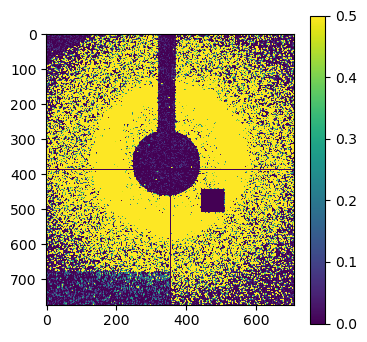

In [13]:
plt.figure(figsize=(4,4))
thick = 70
xx, yy = 440, 440
square = np.ones(shape=saxs.shape)
square[xx:xx+thick, yy:yy+thick] = 0
img = saxs[xx:xx+thick, yy:yy+thick]

plt.imshow(saxs*square, vmin=0, vmax=0.5)
# plt.axvline(x=320, c='w')
# plt.axhline(y=170, c='w')
plt.colorbar()

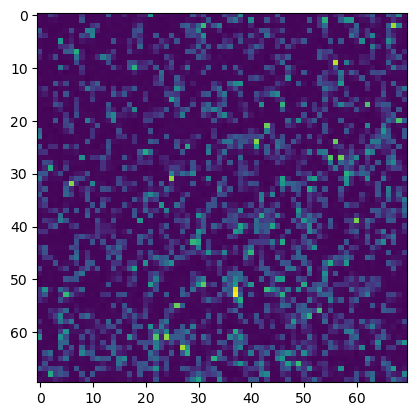

In [14]:
plt.figure()
plt.imshow(img)
plt.title("selected roi")

In [16]:
# plt.figure()
# plt.plot(phi, np.mean(I[:,:],axis=1))
# plt.grid()
# plt.ylabel('I')
# plt.xlabel(r'$\phi$')

Text(0.5, 0, 'q')

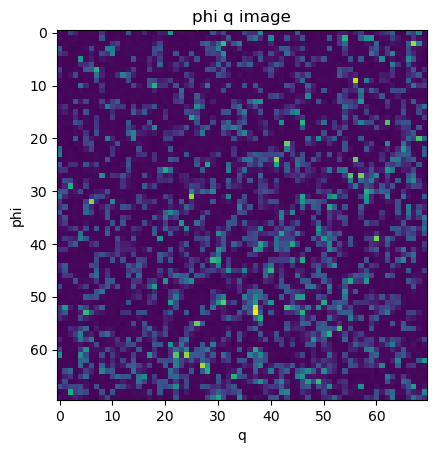

In [17]:
# img = I[:, qmin:qmax] # 

plt.figure()
plt.title('phi q image')
plt.imshow(img)
plt.ylabel('phi')
plt.xlabel('q')

(139, 139) (70, 70)


(40.0, 100.0)

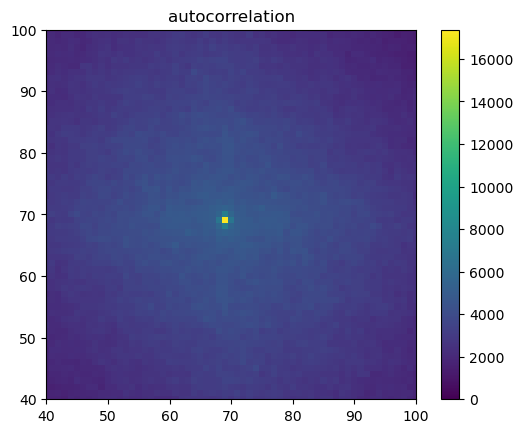

In [70]:
# corr = np.correlate(img.flatten(), img.flatten(), mode='full')
# corr2 = np.corrcoef(img, img)
corr3 = scipy.signal.correlate2d(img/img.mean(), img/img.mean()) 

print(corr3.shape, img.shape)
plt.figure()
plt.title('autocorrelation')
plt.imshow(corr3)#, vmin=0, vmax=1)
# plt.axhline(y=69, c='w')
plt.colorbar()
plt.xlim(40,100)
plt.ylim(40,100)


In [60]:
def gaussian(x, a, x0, sigma, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + c

In [61]:
# constants
h = 4.135667516*1e-18 # kev*sec
c = 3*1e8 # m/s

# setup
sdd = 4.3 # sample-detector distance in meters
energy = 9.5 # energy of the x-rays in keV
wavelength = h*c/energy # wavelength of the x-rays (A-1)
psize = 50e-6 # meter pizel size

Text(0.5, 0, 'pixels')

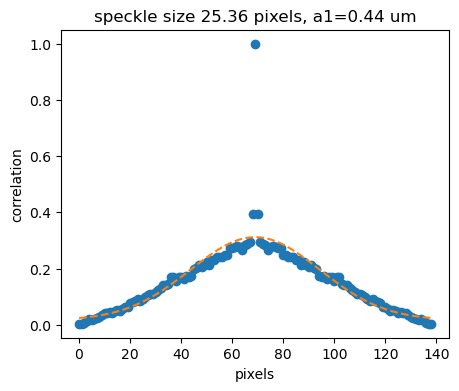

In [80]:
plt.figure(figsize=(5,4))
corr3 = corr3/np.max(corr3)

plt.plot(corr3[69,:]/np.max(corr3), ls='', marker='o')
# plt.xlim(60,80)
x = np.arange(0,len(corr3),1)
x1, x2 = 0,140 #65,74
popt,xc,curve,perr = fit(gaussian, x[x1:x2], corr3[69,x1:x2], p0=[0.25,69,30,5e4]) # a, x0, sigma
plt.plot(xc,curve, ls='--')
sigma = popt[2]*psize # meter
fwhm = 2.355*sigma # sigma
a1 = wavelength * sdd / sigma # meters
# a2 = wavelength * sdd / fwhm # meters
plt.title(f'speckle size {popt[2]:.2f} pixels, a1={a1*1e6:.2f} um')
plt.ylabel('correlation')
plt.xlabel('pixels')

**Estimate expected speckle size**

In [42]:
# constants
h = 4.135667516*1e-18 # kev*sec
c = 3*1e8 # m/s

a = 3e-6 # meter beam size

sdd = 4.3 # sample-detector distance in meters
energy = 9.5 # energy of the x-rays in keV
wavelength = h*c/energy # wavelength of the x-rays (m)

speckle_size = wavelength*sdd/a
speckle_size*1e6/psize

NameError: name 'h' is not defined

In [97]:
# setup
beamstop_radius = 1.5e-3 # meter

# epix params
pixel_size = 50e-6 # meter
npixel = (704, 768)
center = (int(npixel[0]/2), int(npixel[0]/2))

# 4 epix

In [12]:
!ls ../../../shared/output/

contrast_run_38_delay_0.291762952724899_epix_5.npz
contrast_run_38_delay_0.29_epix_5.npz
contrast_run_38_epix_5.npz
contrast_run_43_epix_5.npz
contrast_run_46_epix_5.npz
contrast_run_46.npz
contrast_run_67_epix_5.npz
contrast_run_68_delay_0.22536544064505176.npz
contrast_run_68_delay_0.23.npz
contrast_run_68_epix_5.npz
images


In [13]:
name = 'contrast_run_68_delay_0.23.npz'

file = np.load(outputdir + name)
waxs = {}

for key in file.files:
    waxs[key] = file[key]
    print(key, np.shape(waxs[key]))

beta (4, 4395)
p1 (4, 4395)
p2 (4, 4395)
p0 (4, 4395)
p3 (4, 4395)
kbar (4, 4395)
cc (4395,)
vcc (4395,)
i_sample (4395,)


In [12]:
# f, axs = plt.figure()
# for i in range(waxs['beta'].shape[0]):
#     plt.plot(waxs['beta'][0,:], waxs['kbar'])

# Work on epix5 script

In [14]:
import h5py

In [13]:
def visit_func_original(name, node):
    """Return all groups and datasets name and shapes of h5 file called name
    Use it as in the following:
    with h5py.File(filename, 'a') as f: f.visititems(visit_func)
    """
    if isinstance(node, h5py.Group):
        print("group", node.name)
    elif isinstance(node, h5py.Dataset):
        if (node.dtype == 'object') :
            print (node.name, 'is an object Dataset')
        else:
            print('\t', node.name, node.shape)
    else:
        print(node.name, 'is an unknown type')

In [37]:
def ring(radius=30, thickness=5, nx=704, ny=768, center_x=None, center_y=None):
    '''
    Masking the beam blocker
    nx,ny =  2d pattern dimensions
    center_x, center_y = center of the beam blocker
    radius = radius of the beam blocker
    radius2 = radius of the externa circle (to avoid dip in the angular average)
    '''
    mask = np.zeros((nx,ny),dtype=bool)
    if center_x==None:
        center_x = int(nx/2)
        center_y = int(ny/2)
        
    x,y = np.mgrid[:nx,:ny]
    x -= center_x
    y -= center_y
    rho = np.sqrt(x**2 + y**2)
    condition = (rho<radius) & (rho>radius-thickness)
    mask[condition] = 1
    
    return mask

In [35]:
outdir = '/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/epix5_img/'
roi = np.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/roi_02.npy')
mask = np.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/mask/mask_epix5_231105.npy')

In [34]:
file = 'run119_epix5_indiv_img.h5'

In [127]:
with h5py.File(outdir + file, 'r') as f:
    # f.visititems(visit_func_original)
    img = f['/img'][:100, :, :]

In [25]:
img_avg = np.mean(img, axis=0)

In [51]:
def circle(radius,radius2, xcenter,ycenter, shape):
    c = np.ones([shape[0],shape[1],])
    for x in range(shape[0]):
        for y in range(shape[1]):
            if (((x-xcenter)**2+(y-ycenter)**2)<radius**2)&(((x-xcenter)**2+(y-ycenter)**2)>radius2**2):
                c[x,y]=0   
    return c


In [64]:
print(int(img_avg.shape[0]/2), int(img_avg.shape[1]/2))

386 354


In [73]:
new_roi = ring(radius=200, thickness=30, 
               nx=img_avg.shape[0], ny=img_avg.shape[1], 
               center_x=354, center_y=354)
np.sum(new_roi)
# new_roi[:10]

34824

Text(0.5, 1.0, '(773, 709)')

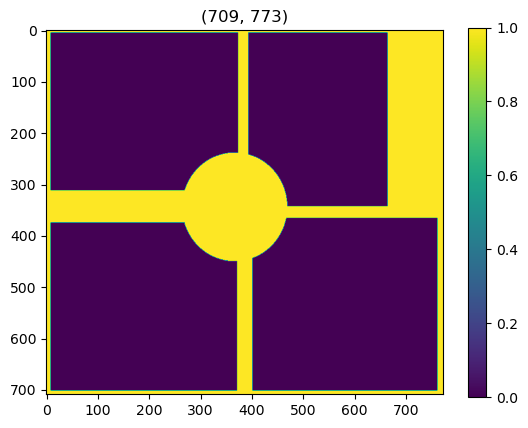

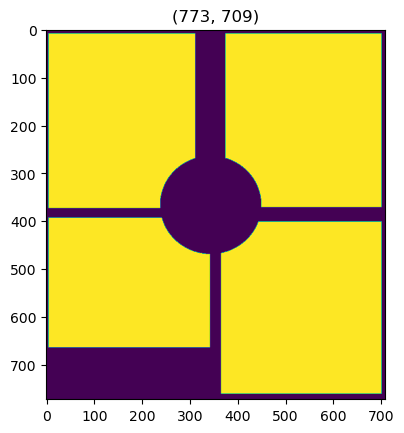

In [92]:
plt.figure()
plt.imshow(mask)
plt.title(np.shape(mask))
plt.colorbar()

plt.figure()
plt.imshow(~mask.T)
plt.title(np.shape(mask.T))

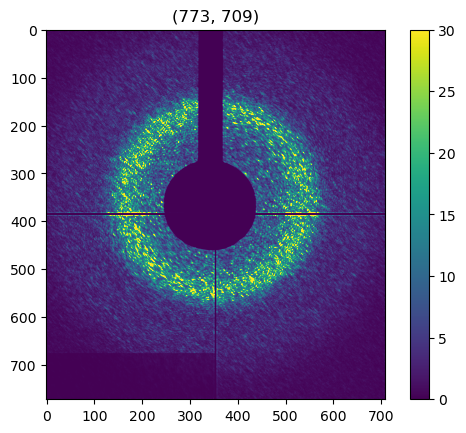

In [86]:
plt.figure()
# plt.imshow(img_avg*mask, vmin=0, vmax=30)
plt.imshow(img_avg, vmin=0, vmax=30)
plt.title(np.shape(img_avg))
plt.colorbar()

In [119]:
roi = np.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/roi_03.npy')
mask = np.load('/sdf/data/lcls/ds/xpp/xppl1001021/results/shared/mask/mask_epix5_231105.npy')
mask = ~(mask.T).astype('bool')
print(np.shape(roi), np.shape(mask))

(773, 709) (773, 709)


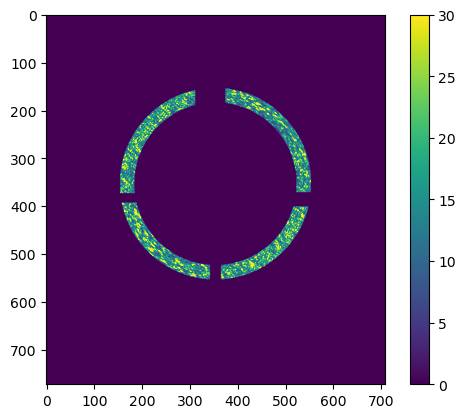

In [123]:
roi_with_mask = roi*mask

plt.figure()
plt.imshow(img_avg*roi_with_mask, vmin=0, vmax=30)
plt.colorbar()
# pixel_num = float(np.sum(roi_with_mask))

In [125]:
pixel_num = float(np.sum(roi_with_mask))
pixel_num

30710.0

In [ ]:
# Create holders for the result
nframe = ds.events() # no need to redefine it

kbar = np.zeros(nframe)
beta = np.zeros(nframe)


# Get the total photon count and probability per shot for all runs and patterns
for i in range(nframe):
    # imgs_reconstruct = reconstruct_img(photons_i[i], photons_j[i], shape)
    img
    kbar[i] = np.sum(img[roi_with_mask])/ pixel_num
    beta[i] = np.var(img[roi_with_mask].flatten())/(kbar[i])**2


In [ ]:
# ds.break_after(100) # stop iteration after 100 events (break statements do not work reliably with MPIDataSource).
t0 = time.time()

kbar = np.zeros(nframe)
beta = np.zeros(nframe)
delays = np.zeros(nframe)

for nevt,evt in enumerate(ds.events()):
    
    if nevt % 500 == 0:
        print(f"done until {nevt}-th img")
        
    printMsg(nevt, evt.run(), ds.rank, ds.size)
    img = det.image(evt)
    stage_value = delay_stage_location(evt)
    
    kbar[nevt] = np.sum(img[roi_with_mask])/ pixel_num
    beta[nevt] = np.var(img[roi_with_mask].flatten())/(kbar[nevt])**2
    delays[nevt] = 0.939 * (stage_value - 6.96)
    

# check saxs new output

In [351]:
!ls /sdf/home/m/mbin/xpp-23-xsvs/results/shared/epix5_img/

log			   run227_epix5_indiv_img.h5  run87_epix5_indiv_img.h5
run119_epix5_indiv_img.h5  run228_epix5_indiv_img.h5  run93_epix5_indiv_img.h5
run132_epix5_indiv_img.h5  run244_epix5_indiv_img.h5
run155_epix5_indiv_img.h5  run261_epix5_indiv_img.h5


In [156]:
plt.rcParams["figure.figsize"] = (4,3)

In [352]:
run = 261
file = f'run{run}_epix5_indiv_img.h5'
direc = '/sdf/home/m/mbin/xpp-23-xsvs/results/shared/epix5_img/'

with h5py.File(direc + file, 'r') as f:
    # f.visititems(visit_func_original)
    beta = f['/beta'][:]
    delays = f['/delay_ps'][:]
    kbar = f['/kbar'][:]

delays = np.array(delays)
kbar = np.array(kbar)
beta = np.array(beta)
print(np.shape(delays))

(20003,)


**Rebin data into binned delays**

In [353]:
delays_unique = np.unique(np.round(delays, 2))
bins_delays = np.linspace(np.min(delays_unique),np.max(delays_unique),10)
delays_r = []

for i in range(len(bins_delays)-1):

    delays_r.append(np.mean(delays[(delays>bins_delays[i]) & (delays<bins_delays[i+1]) ]))
    
    
print(bins_delays, r_delays)

[-0.21  0.12  0.45  0.78  1.11  1.44  1.77  2.1   2.43  2.76] [0.370926341903542, 0.6511428073091297, 0.9310689944250877, 1.211764454857243, 1.4874834254605782, 1.7771057041263594, 2.056256800598032, 2.314725398434144, 2.6216902346394235]


In [354]:
kbar_r =[]
for i in range(len(bins_delays)-1):
    kbar_r.append([])

beta_r =[]
for i in range(len(bins_delays)-1):
    beta_r.append([])

delay_r = []

In [355]:
frames = len(delays)

for i in range(frames):
    for j in range(len(bins_delays)-1):
        if (delays[i]>bins_delays[j]) & (delays[i]<bins_delays[j+1]):
            # np.mean(delays[(delays[i]>bins_delays[i]) & (delays<bins_delays[i+1]) ]
            # delay_r.append()
            kbar_r[j].append(kbar[i])
            beta_r[j].append(beta[i])

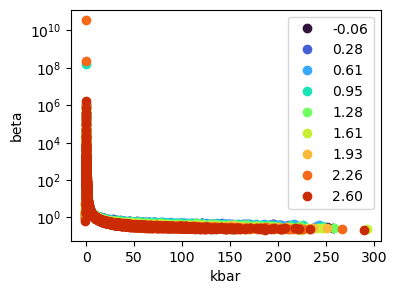

In [356]:
plt.figure()
col = plt.cm.turbo(np.linspace(0,1,len(bins_delays)))

for i,delay in enumerate(delays_r):
    plt.plot(kbar_r[i], beta_r[i], c=col[i], label=f'{delay:.2f}', ls='', marker='o')
    
plt.xlabel('kbar')
plt.ylabel('beta')
plt.legend()
plt.yscale('log')

**Rebinned beta and kbar**

In [357]:
kbar_r2_bins = np.linspace(0, 300, 10)
kbar_r2, beta_r2 = [], []

for delay in range(len(delays_r)):
    kbar_r2.append([])
    beta_r2.append([])
    for i in range(len(kbar_r2_bins)-1):
        beta_r2[delay].append( np.mean( np.array(beta_r[delay])[(kbar_r[delay]>=kbar_r2_bins[i]) & (kbar_r[delay]<kbar_r2_bins[i+1])] ) )
        kbar_r2[delay].append( np.mean( np.array(kbar_r[delay])[(kbar_r[delay]>=kbar_r2_bins[i]) & (kbar_r[delay]<kbar_r2_bins[i+1])] ) )

Text(0, 0.5, 'contrast')

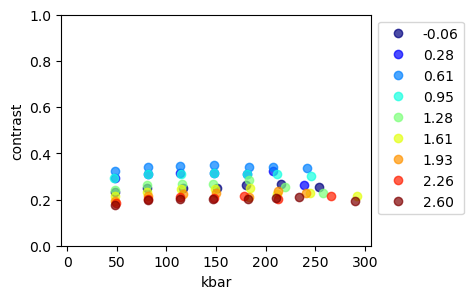

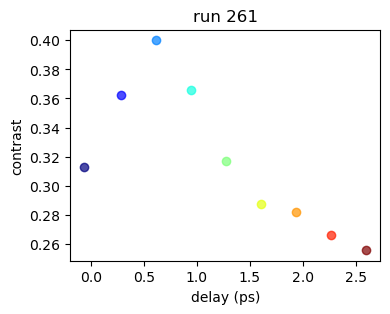

In [359]:
plt.figure()
col = plt.cm.jet(np.linspace(0,1,len(delays_r)))

for i in range(len(delays_r)):
    plt.plot(kbar_r2[i], beta_r2[i]-1/np.array(kbar_r2[i])*9.5, c=col[i], ls='', marker='o', alpha=.7, label=f'{delays_r[i]:.2f}')

plt.xlabel('kbar')
plt.ylabel('contrast')
plt.ylim(0,1)
plt.legend(bbox_to_anchor=[1,1])

plt.figure()
for i in range(len(delays_r)):
    #print(i, kbar_r2[i][:]>200)
    plt.plot(delays_r[i], np.nanmean(np.array(beta_r2[i])[np.array(kbar_r2[i])>100]), c=col[i], ls='', marker='o', alpha=.7, label=f'{delays_r[i]:.2f}')
plt.title(f'run {run}')
plt.xlabel('delay (ps)')
plt.ylabel('contrast')

## other shit

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not jet

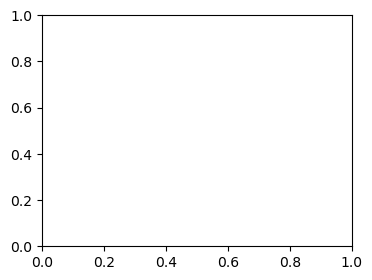

In [321]:
plt.figure()
cols = plt.cm.jet(np.linspace(0,1,len(delays)))
plt.scatter(np.arange(0,len(rebinned_delays),1), rebinned_delays, c='jet')
# plt.scatter(np.arange(0,len(delays),1), delays, c=cols)

In [160]:
bins_delays = np.linspace(min(delays_unique),max(delays_unique),10)

rebinned_delays=[]
rebinned_I=[]
rebinned_beta=[]


for i in range(len(bins_delays)-1):
    rebinned_delays.append(np.mean(delays[(delays>bins_delays[i])&(delays<bins_delays[i+1])]))
    rebinned_I.append(np.mean(kbar[(delays>bins_delays[i])&(delays<bins_delays[i+1])],0))
    rebinned_beta.append(np.mean(beta[(delays>bins_delays[i])&(delays<bins_delays[i+1])],0))

(array([2., 2., 3., 4., 4., 0., 1., 2., 0., 1.]),
 array([20.26157936, 20.6716844 , 21.08178945, 21.49189449, 21.90199953,
        22.31210457, 22.72220962, 23.13231466, 23.5424197 , 23.95252474,
        24.36262978]),
 <BarContainer object of 10 artists>)

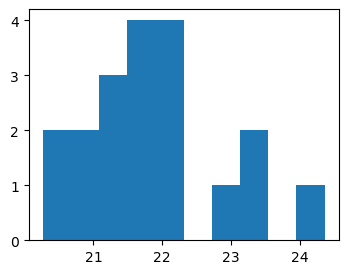

In [161]:
plt.figure()
plt.hist(rebinned_I)

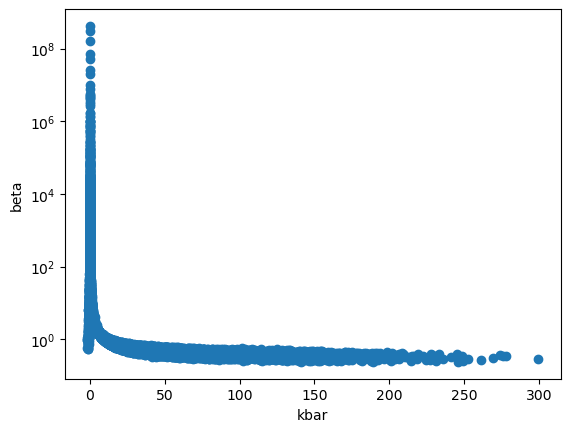

In [153]:
plt.figure()
plt.plot(kbar, beta, ls='', marker='o')
plt.ylabel('beta')
plt.xlabel('kbar')
plt.yscale('log')

Text(0, 0.5, 'beta')

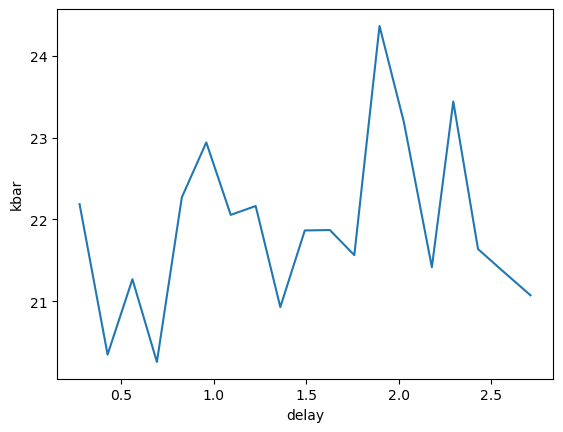

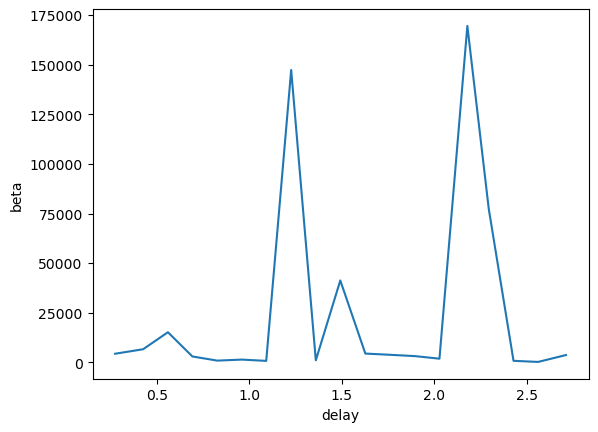

In [143]:
plt.figure()
plt.plot(rebinned_delays, rebinned_I)
plt.xlabel('delay')
plt.ylabel('kbar')

plt.figure()
plt.plot(rebinned_delays, rebinned_beta)
plt.xlabel('delay')
plt.ylabel('beta')